# FILOGER TRASH DETECTION PROJECT:

## Student: Arshia Jafari

In [ ]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, ZeroPadding2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from pathlib import Path
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay


In [ ]:
# import zipfile
# import os

# def unzip_and_save(zip_file, extract_dir):
#     with zipfile.ZipFile(zip_file, 'r') as zip_ref:
#         zip_ref.extractall(extract_dir)

# # Example usage
# zip_file_path = 'Dataset Trash.zip'
# extract_dir = 'data'

# unzip_and_save(zip_file_path, extract_dir)


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


# Preprocessing

In this dataset, we have 6 classes of trash: cardboard, glass, paper, metal, plastic, and other trash. Here, I present 5 images for each class.

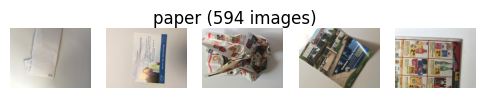

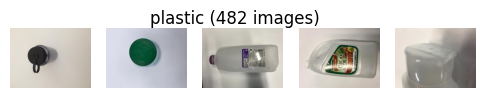

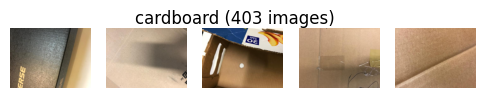

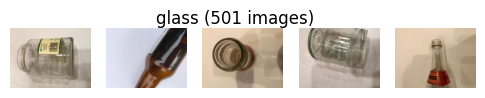

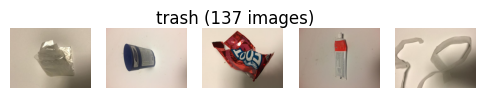

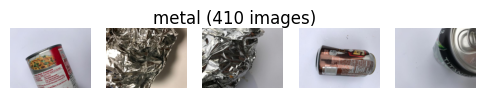

In [ ]:
import matplotlib.pyplot as plt
from pathlib import Path
import random
import cv2

# Dataset path
dataset_path = Path("TrashType_Image_Dataset")
image_list = list(dataset_path.glob("*/*.jpg"))

# Shuffle the images
random.shuffle(image_list)

class_folders = [folder.name for folder in dataset_path.iterdir() if folder.is_dir()]

class_counts = {}

num_images_per_class = 5

for class_folder in class_folders:
    class_path = dataset_path / class_folder

    # List all image files in the class folder
    image_files = list(class_path.glob("*.jpg"))

    # Count the number of images in the class
    num_images = len(image_files)

    # Store the count in the dictionary
    class_counts[class_folder] = num_images

    # Randomly select 5 images from the class
    selected_images = random.sample(image_files, min(num_images_per_class, num_images))

    # Display the images
    plt.figure(figsize=(6, 1))
    plt.suptitle(f"{class_folder} ({num_images} images)")
    for i, image_path in enumerate(selected_images, 1):
        image = plt.imread(image_path)
        plt.subplot(1, num_images_per_class, i)
        plt.imshow(image)
        plt.axis('off')
    plt.show()


Reduce noise in images using Gaussian blur and replace the original images with the preprocessed ones.

**NOTE:** Gaussian blur is a common technique used in image processing to smooth out high-frequency noise while preserving important details in the image.


In [ ]:
# Image Preprocessing

for image_path in image_list:
    img = cv2.imread(str(image_path))

    # Reduce Noises with Gaussian blur
    blur = cv2.GaussianBlur(img, (3, 3), 0)

    # Replace images
    cv2.imwrite(str(image_path), blur)

# Split Train and Test datas

The provided code splits the dataset into training and testing subsets for a deep learning model. Subsequently, it employs data augmentation techniques to generate augmented training data. Here's a review of the purpose and goal based on your description:

**NOTE:** Data Augmentation Techniques: The function employs various data augmentation techniques such as rescaling, flipping, zooming, shifting, rotation, and shear transformation to enhance the diversity and robustness of the training data.

**NOTE:** Generator Configuration: It configures data generators for both training and testing datasets, setting parameters such as target image size, batch size, and data augmentation options.



In [ ]:
def create_data_generators(train_data_dir, test_data_dir, img_size, batch_size):
    """
    Data augmentation for training images:
        Rescale pixel values to the range [0, 1]
        Split 0.2 of datas for validation
        flip images horizontally
        flip images vertically
        zoom images
        shift images horizontally
        shift images vertically
        rotate images
        apply shear transformation
    """

    train_img_generator = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        zoom_range=0.2,
        width_shift_range=0.4,
        height_shift_range=0.4,
        rotation_range=45,
        shear_range=0.3,
        fill_mode='nearest'
    )

    # Rescale pixel values to the range [0, 1]
    test_img_generator = ImageDataGenerator(rescale=1./255, validation_split=0.2)

    # Generate batches of augmented/normalized data for training
    train_generator = train_img_generator.flow_from_directory(
        train_data_dir,
        seed=42,
        target_size=img_size,
        batch_size=batch_size,
        color_mode='rgb',
        class_mode='categorical',
        subset='training'
    )

    # Generate batches of normalized data for validation
    test_generator = test_img_generator.flow_from_directory(
        test_data_dir,
        seed=42,
        color_mode='rgb',
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation',
        shuffle=False
    )

    return train_generator, test_generator

train_data_dir = dataset_path
test_data_dir = dataset_path
img_size = (180, 180)
batch_size = 32

train_generator, test_generator = create_data_generators(train_data_dir, test_data_dir, img_size, batch_size)


Found 2024 images belonging to 6 classes.
Found 503 images belonging to 6 classes.


# Build model
1. **Pre-trained Model**: Start with a pre-trained model that has been trained on a large dataset, often for a general task such as image classification, object detection, or natural language processing. These pre-trained models have learned to extract useful features from the input data.

2. **Feature Extraction**: Use the pre-trained model as a feature extractor by removing the final classification layers. This leaves us with the convolutional base or the feature extraction part of the model, which has learned to recognize patterns and features in the input data.

3. **Training**: Train the model using the new dataset for the target task. Since the pre-trained model has already learned useful representations from a large dataset, it requires less training data and fewer epochs to achieve good performance on the new task.


Advantages of Transfer learning:

1. **Faster Training**: Transfer learning can significantly reduce training time since the model starts with pre-learned features. Training only the additional layers or fine-tuning a few layers is typically faster than training an entire model from scratch.

2. **Better Performance**: By leveraging knowledge learned from a large dataset, transfer learning often leads to better generalization performance, especially when the new task has limited training data.

3. **Handling Data Scarcity**: Transfer learning is particularly useful when the new task has a small or limited dataset. It allows us to effectively utilize the knowledge gained from a larger dataset, improving the model's performance with limited data.





In [ ]:
import tensorflow as tf

def build_model(num_classes):
    # Load pre-trained model
    base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(180, 180, 3))

    base_model.trainable = False

    x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    predictions = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    # Create the model
    model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

    return model

model = build_model(num_classes=6)

# Compile the model
model.compile(optimizer='Adam',
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])

58889256/58889256 [==============================] - 0s 0us/step


# Train model

Train the model with 30 epochs and utilize the Early Stopping callback

**NOTE**: Early Stopping is a technique used to prevent overfitting by monitoring a specified metric (validation loss) and stopping training when the metric stops improving for a specified number of epochs (patience).

**NOTE**: Recommend training this model with GPU runtime, such as T4, to reduce fitting time.

In [ ]:
# Model training
ES = EarlyStopping(monitor='val_loss', mode='min', patience=10)
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=30,
    callbacks=[ES]
)

Epoch 1/30
64/64 [==============================] - 35s 409ms/step - loss: 1.5185 - accuracy: 0.3686 - val_loss: 1.1551 - val_accuracy: 0.5507
Epoch 2/30
64/64 [==============================] - 31s 492ms/step - loss: 1.2485 - accuracy: 0.5089 - val_loss: 1.0295 - val_accuracy: 0.6203
Epoch 3/30
64/64 [==============================] - 28s 437ms/step - loss: 1.1701 - accuracy: 0.5331 - val_loss: 1.0194 - val_accuracy: 0.6163
Epoch 4/30
64/64 [==============================] - 25s 396ms/step - loss: 1.0908 - accuracy: 0.5667 - val_loss: 0.9477 - val_accuracy: 0.6561
Epoch 5/30
64/64 [==============================] - 24s 381ms/step - loss: 1.0571 - accuracy: 0.5879 - val_loss: 0.9241 - val_accuracy: 0.6879
Epoch 6/30
64/64 [==============================] - 23s 355ms/step - loss: 1.0218 - accuracy: 0.6018 - val_loss: 0.9076 - val_accuracy: 0.6859
Epoch 7/30
64/64 [==============================] - 24s 373ms/step - loss: 1.0027 - accuracy: 0.6225 - val_loss: 0.8846 - val_accuracy: 0.7038

# Final evaluations

In [ ]:
# Predict the model

y_pred = model.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)

16/16 [==============================] - 2s 97ms/step


Metrics to evaluate the final model

1. **Accuracy**: Accuracy measures the proportion of correctly classified instances among all instances. It is computed using the accuracy_score function from sklearn.metrics. In this code, it calculates the accuracy by comparing the true class labels (test_generator.classes) with the predicted class labels (y_pred).

2. **Precision**, **Recall**, and **F1-score**: Precision measures the proportion of true positive predictions among all positive predictions, while recall measures the proportion of true positive predictions among all actual positive instances. The F1-score is the harmonic mean of precision and recall, providing a single metric that balances both measures.

These metrics are computed using the `precision_recall_fscore_support` and `accuracy_score` function from sklearn.metrics. The 'weighted' average is used to account for class imbalance.


In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Compute accuracy
accuracy = accuracy_score(test_generator.classes, y_pred)

# Compute precision, recall, and F1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(test_generator.classes, y_pred, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score)


Accuracy: 0.73558648111332
Precision: 0.7450762777488686
Recall: 0.73558648111332
F1-score: 0.7349523419644336


**Confusion Matrix**:

A confusion matrix is a visualization tool used in machine learning and classification tasks to assess the performance of a model. It provides a comprehensive summary of the model's predictions compared to the actual ground truth across different classes.



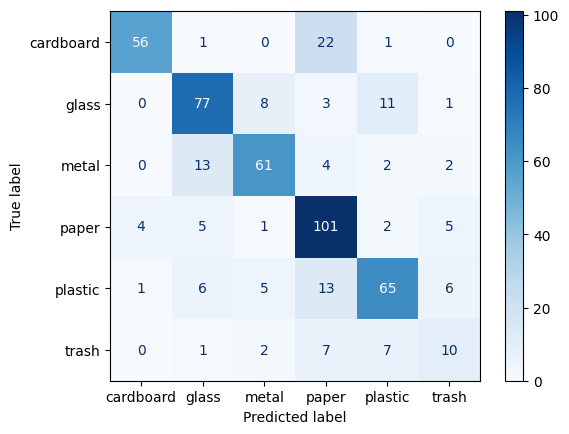

In [ ]:
# Confusion Matrix

cm = confusion_matrix(test_generator.classes, y_pred)
labels = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Visualize loss and accuracy for both training and validation datasets across epochs.

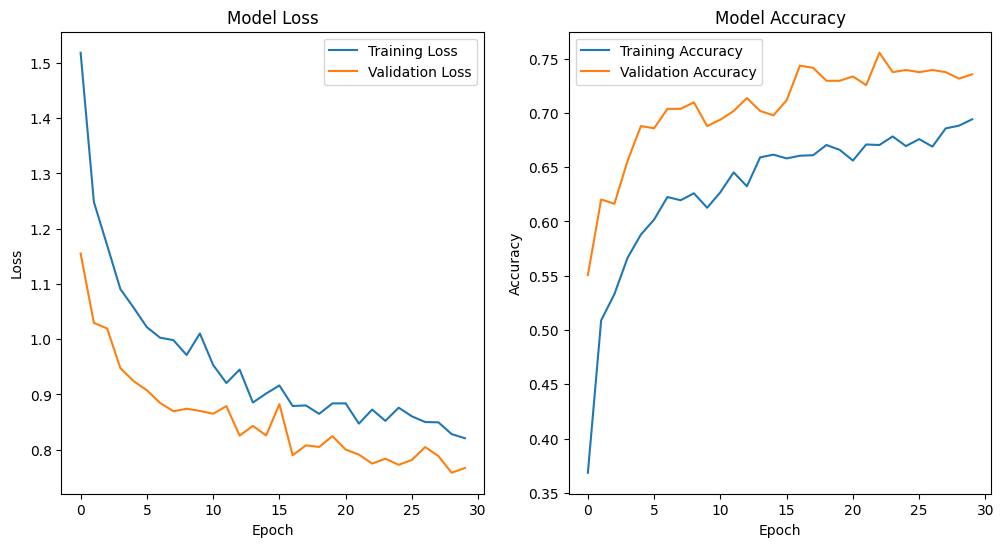

In [ ]:
import matplotlib.pyplot as plt

# Plot training history
plt.figure(figsize=(12, 6))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Check the model with an image that is not in the dataset.

1/1 [==============================] - 1s 1s/step


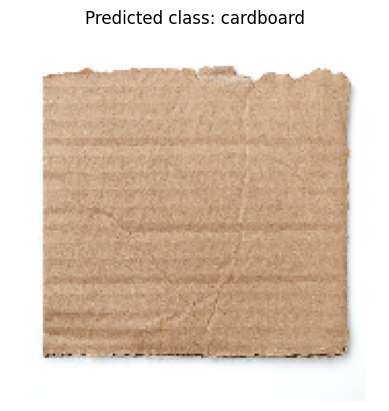

In [ ]:
import matplotlib.pyplot as plt

# Load the image
image_path = "tst.jpg"
image = tf.keras.preprocessing.image.load_img(image_path, target_size=(180, 180))

# Convert the image to a numpy array
image_array = tf.keras.preprocessing.image.img_to_array(image)

image_array = np.expand_dims(image_array, axis=0)

# Rescale to the range [0, 1]
image_array = image_array / 255.0  # Assuming your model expects input in the range [0, 1]

# Use your trained model to make predictions
predictions = model.predict(image_array)

# Get the class with the highest probability
predicted_class = np.argmax(predictions)

classes = train_generator.class_indices

for key, value in classes.items():
    if value == predicted_class:
        class_label = key

# Show the image
plt.imshow(image)
plt.title(f"Predicted class: {class_label}")
plt.axis('off')
plt.show()
